In [175]:
# modules for structure decoration
import os
import itertools
from tqdm.notebook import tqdm
import glob
from glob import iglob
from copy import deepcopy
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

from pymatgen.core import Composition, Structure
from pymatgen.analysis import local_env

pandas version: 1.1.4
numpy version: 1.21.0
matplotlib version: 3.4.2
seaborn version: 0.11.1


In [70]:
os.chdir('../../')
print(os.getcwd())
from src import utils
import preprocess_crystals as preprocess

/lustre/eaglefs/projects/rlmolecule/jlaw/crystal-gnn-fork


RDKit WARNING: [05:39:57] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
# print(f"pymatgen version: {pymatgen.__version__}")
import pip
pip.main(["show","pymatgen"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Name: pymatgen
Version: 2022.0.8
Summary: Python Materials Genomics is a robust materials analysis code that defines core object representations for structures and molecules with support for many electronic structure codes. It is currently the core analysis code powering the Materials Project (https://www.materialsproject.org).
Home-page: http://www.pymatgen.org
Author: Pymatgen Development Team
Author-email: ongsp@eng.ucsd.edu
License: MIT
Location: /home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages
Requires: requests, ruamel.yaml, monty, numpy, networkx, scipy, sympy, plotly, uncertainties, tabulate, pandas, matplotlib, palettable, spglib
Required-by: pyxtal


0

## Mean Displacement


In [57]:
# Oops, the site coordinates are already the cartesian coordinates!
# def convert_frac_to_cartesian_coords(site, latt_mat):
#     """
#     Taken from here: https://www.vasp.at/wiki/index.php/POSCAR
    
#     :param site: pymatgen structure site with fractional coordinates
#     :param latt_mat: pymatgen lattice matrix for the structure    
#     """
    
#     coords = (site.x * latt_mat[0]) + (site.y * latt_mat[1]) + (site.z * latt_mat[2])
#     return np.asarray(coords)

In [163]:
def dist_from_unrel_to_relaxed(strc1, strc2):
    """ Compute how much each atom moved after DFT relaxation. 
    For every point in strc1, it will compute the euclidean distance to the same site in strc2
    """
    distances = []
    latt_mat1 = strc1.lattice._matrix
    latt_mat2 = strc2.lattice._matrix
    for i, s1 in enumerate(strc1.sites):
        s2 = strc2.sites[i]
#         if fractional: 
        dist = np.linalg.norm(s1.coords - s2.coords)
#         else:
#             # convert the fractional corrdinates to cartesian
#             s1_coords = convert_frac_to_cartesian_coords(s1, latt_mat1)
#             s2_coords = convert_frac_to_cartesian_coords(s2, latt_mat2)
#             # frobineus norm, which is:
#             # np.sum((s1_coords - s2_coords)**2)**.5
#             dist = np.linalg.norm(s1_coords - s2_coords)
        distances.append(dist)
        
    return distances

In [109]:
def dist_all_strcs(hypo_pred_df, unrelaxed_structures, relaxed_structures):
    """
    :param hypo_pred_df: dataframe with the predicted energy per atom, and the DFT relaxed energy per atom
    :param unrelaxed_structures: dictionary with the structure ID as the key and the pymatgen structure as the value
    :param relaxed_structures: IDs must match the unrelaxed structures. Should have the structures after DFT relaxation
    """
#     hypo_pred_df.energyperatom, 
#     hypo_pred_df.predicted_energyperatom, 
    distances = {}
    for strc_id in hypo_pred_df.id:
        unrel_strc = unrelaxed_structures[strc_id]
        rel_strc = relaxed_structures[strc_id]
        dist = dist_from_unrel_to_relaxed(unrel_strc, rel_strc)
        distances[strc_id] = dist
    return distances

In [79]:
loaded_datasets = {}
def load_datasets(config_map, experiment):
    """ 
    """
    hypo_df = pd.DataFrame()
    datasets = config_map['datasets']
    unrel_name = [d for d in experiment['datasets'] if not datasets[d].get('relaxed', True)][0]
    print(unrel_name)
    rel_name = datasets[unrel_name]['relaxed_dataset']
    
    for dataset_name in [unrel_name, rel_name]:
        dataset = datasets[dataset_name]
        curr_df = loaded_datasets.get(dataset_name)
        if curr_df is None:
            curr_df = preprocess.load_hypothetical_structures(
                dataset['relaxed_energies'], dataset['structures_file'])
            # keep track of if these structures are relaxed or not
            curr_df['relaxed'] = dataset['relaxed']

        hypo_df = pd.concat([hypo_df, curr_df])
        loaded_datasets[dataset_name] = curr_df
    
    return hypo_df

In [211]:
def plot_err_by_dist(hypo_pred_df, unrel_to_rel_distances, exp_dir, out_dir=None):
    mean_dist = {s: np.mean(d) for s, d in unrel_to_rel_distances.items()}
    df = hypo_pred_df.set_index('id')
    df['distances'] = pd.Series(mean_dist)
    df['pred_err'] = abs(df['predicted_energyperatom'] - df['energyperatom'])
#     df['pred_err'] = df['predicted_energyperatom'] - df['energyperatom']
    
    df[df['distances'] < 250].plot.scatter('distances', 'pred_err', s=2, alpha=.5)
    plt.xlabel("Mean distance from unrelaxed to relaxed")
    if out_dir is not None:
        out_file = f"{out_dir}/{'_'.join(exp_dir.split('/')[-2:])}-scatter.svg"
        print(f"writing {out_file}")
        plt.savefig(out_file, bbox_inches='tight')
    plt.show()
    plt.close()
    
    sns.jointplot(x='distances', y='pred_err', data=df,
              xlim=(0,10), ylim=(0,.75), 
              kind='hex', #color="#4CB391",
             )
    if out_dir is not None:
        out_file = f"{out_dir}/{'_'.join(exp_dir.split('/')[-2:])}-hex.svg"
        plt.savefig(out_file, bbox_inches='tight')
    plt.show()
    plt.close()

In [164]:
# for config_file in ['config/battery-unrelaxed.yaml']:
#     config_map = utils.load_config_file(config_file)
#     unrel_to_rel_distances, hypo_pred_df = main(config_map)

Loading config file 'config/battery-unrelaxed.yaml'
4 experiments. Just running the first one
{'datasets': ['icsd', 'battery_unrelaxed'], 'eval_settings': {'icsd_lattice': 'orig', 'hypo_lattice': 'orig', 'icsd': {'random_subset': 0.05}, 'hypo': 'leave_out_comp', 'seed': 2}}
battery_unrelaxed
   comp_type composition                            id  energyperatom  \
0        112    Mg2Cl1P1    Mg2Cl1P1_sg2_icsd_035676_1      -3.527097   
1        112    Mg2Cl1P1   Mg2Cl1P1_sg55_icsd_642437_1      -3.365935   
2        112    Mg2Cl1P1  Mg2Cl1P1_sg194_icsd_061381_1      -3.562473   
3        112    Mg2Cl1P1   Mg2Cl1P1_sg53_icsd_071063_1      -3.233444   
4        112    Mg2Cl1P1  Mg2Cl1P1_sg146_icsd_174547_1      -3.551902   

                                             crystal  relaxed  
0  [[2.82317897 6.59904178 1.05322086] Cl, [9.969...    False  
1  [[6.0667  2.76115 2.25676] Cl, [4.2333  8.5088...    False  
2  [[8.79887274e-17 3.17222275e+00 3.75750000e+00...    False  
3  [[3.9485 

<AxesSubplot:>

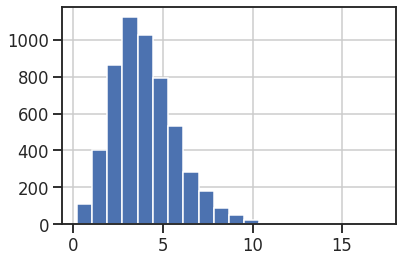

In [196]:
mean_dist = {s: np.mean(d) for s, d in unrel_to_rel_distances.items()}
S_mean = pd.Series(mean_dist.values())
S_mean.hist(bins=20)

<AxesSubplot:>

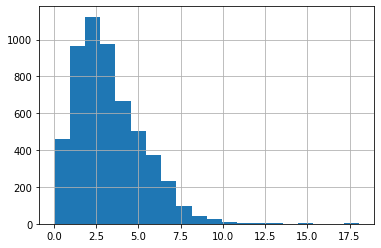

In [167]:
mean_dist = {s: np.median(d) for s, d in unrel_to_rel_distances.items()}
S_mean = pd.Series(mean_dist.values())
S_mean.hist(bins=20)

In [197]:
# now plot the mean distance vs error
df = hypo_pred_df.set_index('id')
df['distances'] = pd.Series(mean_dist)
df['pred_err'] = abs(df['predicted_energyperatom'] - df['energyperatom'])
df.head()

,comp_type,composition,energyperatom,predicted_energyperatom,distances,pred_err
id,,,,,,
Zn1Hg1S2_sg2_icsd_035676_1,112.0,Zn1Hg1S2,-2.830039,-2.683187,2.702001,0.146852
Zn1Hg1S2_sg194_icsd_061381_1,112.0,Zn1Hg1S2,-2.790234,-2.468518,7.221195,0.321716
Zn1Hg1S2_sg53_icsd_071063_1,112.0,Zn1Hg1S2,-2.689005,-2.666391,1.867707,0.022614
Zn1Hg1S2_sg146_icsd_174547_1,112.0,Zn1Hg1S2,-2.734635,-2.762897,2.457369,0.028263
Zn1Hg1S2_sg113_icsd_160121_1,112.0,Zn1Hg1S2,-2.636409,-2.620141,3.635054,0.016268


Text(0.5, 0, 'Mean distance from unrelaxed to relaxed')

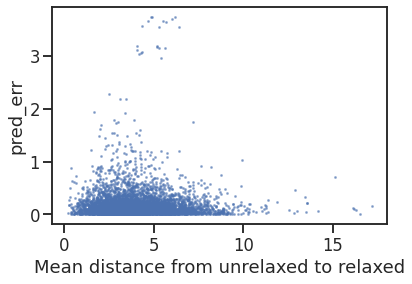

In [202]:
df[df['distances'] < 250].plot.scatter('distances', 'pred_err', s=2, alpha=.5)
plt.xlabel("Mean distance from unrelaxed to relaxed")

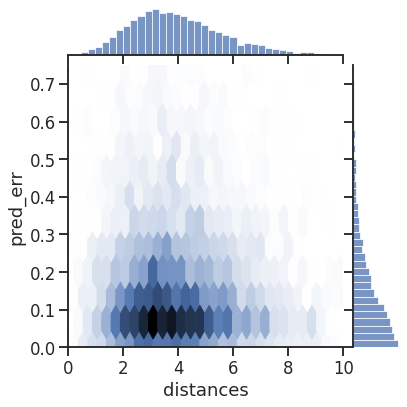

In [203]:
sns.jointplot(x='distances', y='pred_err', data=df,
              xlim=(0,10), ylim=(0,.75), 
              kind='hex', #color="#4CB391",
             )